In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("dark")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
engagements = pd.read_csv('daily_engagement.csv')
enrollments = pd.read_csv('enrollments.csv')
submissions = pd.read_csv('project_submissions.csv')

# Remove test accounts
udacity_accts = set(enrollments[enrollments['is_udacity'] == True]['account_key'])

enrollments = enrollments[enrollments['is_udacity'] == False]
engagements = engagements[~engagements['account_key'].isin(udacity_accts)]
submissions = submissions[~submissions['account_key'].isin(udacity_accts)]

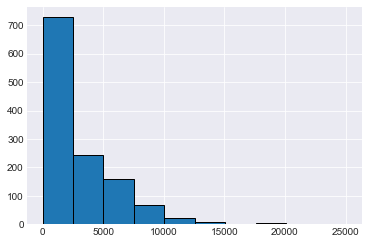

In [50]:
# Histogram of total minutes visited per student
engagements.groupby('account_key').sum().total_minutes_visited.hist(edgecolor='black')

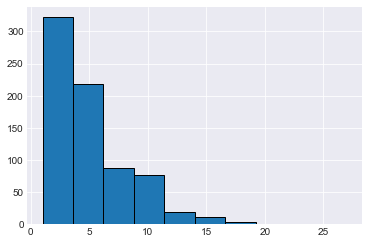

In [49]:
# Number of submissions per student
submissions['account_key'].value_counts().hist(edgecolor='black')

In [3]:
# Pivot: days as columns, students as rows, time as cells
data = engagements.pivot_table(index='account_key', columns='utc_date',
                                  values='total_minutes_visited').fillna(0)
data = data.reset_index()

completed_projects = engagements.groupby('account_key').sum()\
[['total_minutes_visited', 'lessons_completed', 'projects_completed']]

data = data.merge(submissions[['assigned_rating', 'account_key']],
                        how='left', on='account_key')

# Total time in the classroom
data['total_minutes'] = data.sum(axis=1)

# Completed projects (not used for machine learning)
data['projects'] = completed_projects['projects_completed']

# Make "passed" a binary variable
data['passed'] = np.where((data['assigned_rating'] == 'PASSED') |\
                             (data['assigned_rating'] == 'DISTINCTION'),
                            1, 0)

# Students can make multiple submissions. If a submission is eventually
# accepted, then the student should be marked passing for each previous
# submission. This is necessary for machine learning.
passing_students = set(data[data['passed'] == 1]['account_key'])
data['passed'] = np.where(data['account_key'].isin(passing_students), 1, 0)

In [4]:
# Collapse all submissions into a single record per student.
# This works because of the 'passed' feature we just created.
data = data.groupby('account_key').mean()

In [6]:
# Record number of days the student logged in.
data['days_logged_in'] = data[data>0].drop(['total_minutes', 'projects', 'passed'],
                                           axis=1).count(axis=1)

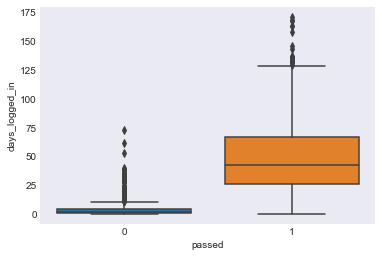

In [54]:
sns.boxplot(y='days_logged_in', x='passed', data=data)

# Machine Learning

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Shuffle (just in case)
data = data.sample(frac=1.0).fillna(0)

# All we'll look at is total time and days logged in
x = data[['days_logged_in', 'total_minutes']]
y = data['passed']

clf = LogisticRegression()

cv = cross_val_score(clf, x, y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.96241782788583019, 0.014868232777194958)

In [61]:
# XGBoost isn't really any better!

clf = XGBClassifier(max_depth=2)

cv = cross_val_score(clf, x, y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.96276100730907854, 0.018904147111033009)

In [ ]:
# Code sandbox below (ignore!)

In [174]:
engagements_sum = engagements.groupby('account_key').sum()
engagements_sum.columns = ['e_sum_' + str(i) for i in engagements_sum.columns]
engagements_count = engagements.groupby('account_key').count()
engagements_count.columns = ['e_count_' + str(i) for i in engagements_count.columns]
engagements_mean = engagements.groupby('account_key').mean()
engagements_mean.columns = ['e_mean_' + str(i) for i in engagements_mean.columns]

engagements_sum = engagements_sum.reset_index()
engagements_count = engagements_count.reset_index()
engagements_mean = engagements_mean.reset_index()

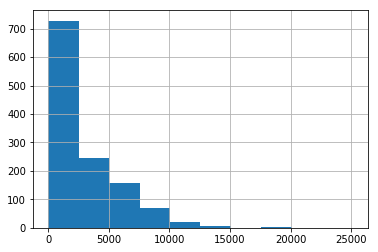

In [176]:
enrollments = enrollments.merge(engagements_sum, how='outer', on='account_key')
enrollments = enrollments.merge(engagements_count, how='outer', on='account_key')
# enrollments = enrollments.merge(engagements_mean, how='outer', on='account_key')

In [177]:
submissions = submissions.merge(enrollments, how='inner', on='account_key')

data = submissions.copy()
data = data[data.lesson_key == 3176718735]
for i in data.drop('assigned_rating', axis=1).columns:
    #if 'e_' not in i: del data[i]
    if 'projects_com' in i: del data[i]
    elif data[i].nunique() == 1: del data[i]

In [178]:
y = np.where((data['assigned_rating'] == 'PASSED') |\
             (data['assigned_rating'] == 'DISTINCTION'),
              1, 0)
x = data.select_dtypes('number')

In [179]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

xg = XGBRegressor(max_depth=2)

cv = cross_val_score(xg, x, y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.55806347754029817, 0.0096604869025730417)

In [180]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

xg = LogisticRegression()

cv = cross_val_score(xg, x.fillna(x.median()), y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.54814087230617903, 0.020394817035493781)

In [181]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

xg = DecisionTreeClassifier(max_depth=3)

cv = cross_val_score(xg, x.fillna(x.median()), y, scoring='roc_auc', cv=4)

cv.mean(), cv.std()

(0.56049947056957539, 0.015848446398880483)

In [169]:
data.shape

(1941, 17)

In [261]:
submissions

,creation_date,completion_date,assigned_rating,account_key,lesson_key,processing_state
0,2015-01-14,2015-01-16,UNGRADED,256,3176718735,EVALUATED
1,2015-01-10,2015-01-13,INCOMPLETE,256,3176718735,EVALUATED
2,2015-01-20,2015-01-20,PASSED,256,3176718735,EVALUATED
3,2015-03-10,2015-03-13,PASSED,434,3176718735,EVALUATED
4,2015-02-17,2015-03-03,INCOMPLETE,434,3176718735,EVALUATED
5,2015-04-06,2015-04-06,INCOMPLETE,381,3176718735,EVALUATED
6,2015-07-26,2015-07-28,INCOMPLETE,381,3165188753,EVALUATED
7,2015-05-31,2015-06-02,PASSED,381,3168208620,EVALUATED
8,2015-07-29,2015-07-29,PASSED,381,3165188753,EVALUATED
9,2015-07-29,2015-07-29,INCOMPLETE,381,3165188753,EVALUATED
